
# Sample complexity for MW2



In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns
import scipy
import sklearn
import time
import pandas as pd
import scipy.stats as sps
import scipy.linalg as spl
from scipy.optimize import linprog
from torch.autograd import Variable
sns.set(color_codes=True)
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.set_style("whitegrid")
from sklearn.mixture import GaussianMixture as gmm


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Used device: '+device)

!pip install pot
import ot


Used device: cpu
     |████████████████████████████████| 440kB 6.1MB/s 


In [ ]:
## utilitary functions

def plotGMM(w,m,cov):
  """
  From N. Courty
  """
  mix = gmm(n_components=w.shape[0],covariance_type='full')
  mix.weights_ = w
  mix.means_ = m
  mix.covariances_ = cov
  mix.precisions_cholesky_ = 0
  samples=mix.sample(1000)
  sns.kdeplot(samples[0][:,0],samples[0][:,1], cmap=cmap, n_levels=10, shade=False)


def sample_random_GMM(k, dim, N_pts, weights=None, means=None, covs=None):
  """
  Generation of ramdom GMM with k nodes, in dimension dim
  Output : Samples from the mixture and its true underlying parameters
  """
  if weights is None :
    weights = torch.rand(k)
  if means is None :
    means = torch.rand((k, dim))
  if covs is None:
    sigma = np.random.randn(k, dim, dim) * 0.6
    covs = sigma@sigma.transpose(0,2,1) ## enforcing covariance matrix to be SDP 

  weights, means, covs = torch.tensor(weights), torch.tensor(means), torch.tensor(covs)
  weights = weights/torch.sum(weights)
  X = torch.tensor([])

  for i in range(k):
    pi = weights[i]
    mean = means[i]
    cov = covs[i]
    if dim ==1 :  
      sigma_sqrt = torch.sqrt(torch.ravel(cov))
      mean = torch.ravel(mean)
      X = torch.cat((X, mean + sigma_sqrt * torch.randn(int(pi * N_pts))))
 
    else : 
      repeats_array = torch.tile(mean, (int(pi * N_pts), 1))
      sigma_sqrt = torch.tensor(np.real(scipy.linalg.sqrtm(cov))).double()
      X = torch.cat((X,torch.tensor(scipy.stats.multivariate_normal.rvs(mean=np.zeros(dim),size=int(pi * N_pts))) @ sigma_sqrt + repeats_array))
  return X.clone().detach().numpy(), means.clone().detach().numpy(), covs.clone().detach().numpy(), weights.clone().detach().numpy()


def GaussianW2(m0,m1,Sigma0,Sigma1):
    """
    From J.Delon
    Computes the quadratic Wasserstein distance between two Gaussians with means m0 and m1 and covariances Sigma0 and Sigma1
    """
    ## if dimension 1 (because sqrtm applies only to matrices)
    if np.shape(m0)[0] ==1 : 
      #print("Dimension 1")
      return (m0-m1)**2 + (Sigma0 - Sigma1)**2
    Sigma00  = spl.sqrtm(Sigma0)
    Sigma010 = spl.sqrtm(Sigma00@Sigma1@Sigma00)
    d        = np.linalg.norm(m0-m1)**2+np.trace(Sigma0+Sigma1-2*Sigma010)
    return d

def GW2(pi0,pi1,mu0,mu1,S0,S1):
    """
    From J.Delon
    Returns the GW2 discrete map and the GW2 distance between two GMM
    """
    K0 = mu0.shape[0]
    K1 = mu1.shape[0]
    d  = mu0.shape[1]
    S0 = S0.reshape(K0,d,d)
    S1 = S1.reshape(K1,d,d)
    M  = np.zeros((K0,K1))
    # First we compute the distance matrix between all Gaussians pairwise
    for k in range(K0):
        for l in range(K1):
            M[k,l]  = GaussianW2(mu0[k,:],mu1[l,:],S0[k,:,:],S1[l,:,:])
    # Then we compute the OT distance or OT map thanks to the OT library
    wstar     = ot.emd(pi0,pi1,M)         # discrete transport plan
    distGW2   = np.sum(wstar*M)
    return wstar,distGW2

def distance_bures(Sigma0,Sigma1):
    Sigma00  = spl.sqrtm(Sigma0)
    Sigma010 = spl.sqrtm(Sigma00@Sigma1@Sigma00)
    d_bures       = np.trace(Sigma0+Sigma1-2*Sigma010)
    return d_bures

# I. For one gaussian in the mixture : MW_2 = W_2

In [ ]:
## for one gaussian in the mixture in any dimension

def empirical_mean(X):
  n = np.shape(X)[0]
  mu_X = np.array([1/n * np.sum(X, axis=0)])
  return mu_X.reshape(-1)

def empirical_cov(X, mu=None):
  n = np.shape(X)[0]

  ## to avoid redundant computations if we already called empirical_mean previously
  if mu is None:
    mu = empirical_mean(X)
  
  mu = mu.reshape(1,-1)
  if len(np.shape(X))==1:
    repeat_array = np.tile(mu, (n, 1))
    return np.array([1/(n-1) * np.sum((X - mu)**2)])

  else: ## dimension larger than 1
    d = np.shape(X)[1]
    mu = empirical_mean(X)
    mu = mu.reshape(d,-1)
    matr = (X - np.ones(n).reshape(n,-1) @ mu.T).T @ (X - np.ones(n).reshape(n,-1) @ mu.T)
    return 1/(n-1) * matr ## unbiased estimate

In [ ]:
def expectation(w0,m0,S0,w1,m1,S1, n, dim=1, k=1, nb_iter=10000):
  epsilon = 1e-10
  E = np.zeros(nb_iter)

  for i in range(nb_iter):

    ## generation of samples 
    X, trueX_means, trueX_covs,trueX_weights = sample_random_GMM(k, dim, n,w0,m0,S0) ## generation of GMM samples with 1 component
    Y, trueY_means, trueY_covs,trueY_weights = sample_random_GMM(k, dim, n,w1,m1,S1) ## generation of GMM samples with 1 component

    assert n == np.shape(X)[0], 'number of samples of X incorrect'
    assert n == np.shape(Y)[0], 'number of samples of Y incorrect'
    mu_X, mu_Y = empirical_mean(X), empirical_mean(Y)
    cov_X, cov_Y = epsilon *np.eye(dim) + empirical_cov(X, mu_X), epsilon *np.eye(dim) + empirical_cov(Y, mu_Y) ## to avoid singular matrices
    E[i] = GaussianW2(mu_X, mu_Y, cov_X, cov_Y)
  return E.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1D gaussian with true mean  0.513
Empirical mean  0.526
1D gaussian with true covariance  0.285
Empirical Covariance  0.28


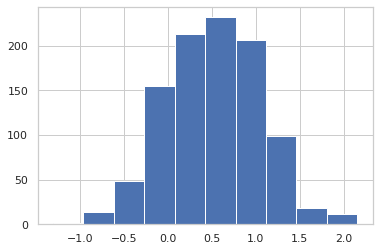

In [ ]:
## if dimension 1 : check if realizations match the theoretical distribution

k=1
dim = 1
N_pts =1000
X, true_means, true_covs,true_weights = sample_random_GMM(k, dim, N_pts) ## generation of GMM samples

pl.hist(X)
print("1D gaussian with true mean ",round(np.ravel(true_means)[0],3))
mu = empirical_mean(X)
print("Empirical mean ", round(mu[0], 3))

print("1D gaussian with true covariance ",round(np.ravel(true_covs)[0],3))
print("Empirical Covariance ", round(empirical_cov(X, mu)[0], 3))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


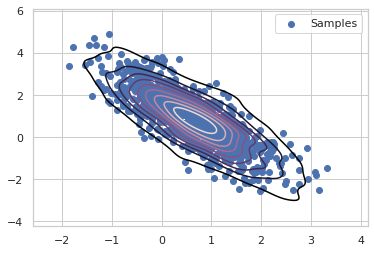

In [ ]:
## if dimension 2 : check if realizations match the theoretical distribution

k=1
dim = 2
N_pts =1000
X, true_means, true_covs,true_weights = sample_random_GMM(k, dim, N_pts) ## generation of GMM samples

plotGMM(true_weights, true_means, true_covs)
pl.scatter(X[:,0], X[:,1],label="Samples")
pl.legend()
pl.show()

In [ ]:
## Test empirical estimates
print(15*'*', "Mean", 15*'*')
print("True ", true_means)
mu = empirical_mean(X)
print("Empirical ", mu,"\n \n")

print(15*'*', "Covariance", 15*'*')
print("True ", true_covs)
print("Empirical ", empirical_cov(X, mu))

*************** Mean ***************
True  [[0.66670984 0.8058815 ]]
Empirical  [0.61237381 0.87163891] 
 

*************** Covariance ***************
True  [[[ 0.70008475 -0.87076864]
  [-0.87076864  1.70287933]]]
Empirical  [[ 0.6829416  -0.85253806]
 [-0.85253806  1.67204594]]


Let us check empirically that for $\mu_0, \mu_1$ two gaussians, the $MW_2^2$ is consistent.

Note : for two gaussians, $MW_2^2(\mu_0, \mu_1) = W_2^2(\mu_0, \mu_1)$



**1.   Dimension 1**

\begin{aligned}
\mathbb{E}_{X,Y}[(\bar X_n - \bar Y_n)^2 + (\bar \sigma_n^X - \bar \sigma_n^Y)^2] - MW_2^2(\mu_0, \mu_1) = \mathcal{O}(\frac{1}{n})
\end{aligned}

Where 
\begin{aligned}
MW_2^2(\mu_0, \mu_1) = ||m_0 - m_1||^2 + (\sigma_0 - \sigma_1)^2
\end{aligned}


In [ ]:
# with 1 gaussian GMM

## test in dimension 1

pi0 = np.array([1])
mu0 = np.array([[.2]]).T
S0  = np.array([[.0009]])

pi1 = np.array([.2])    
mu1 = np.array([[.7]]).T
S1  = np.array([[.0009]])

MW = GaussianW2(mu0,mu1,S0,S1).ravel()
consistences = []
list_n = np.arange(2, 200)
for n in list_n:
  E = expectation(pi0,mu0,S0,pi1,mu1,S1,n)
  consistences.append(E - MW[0])

consistences = np.array(consistences)

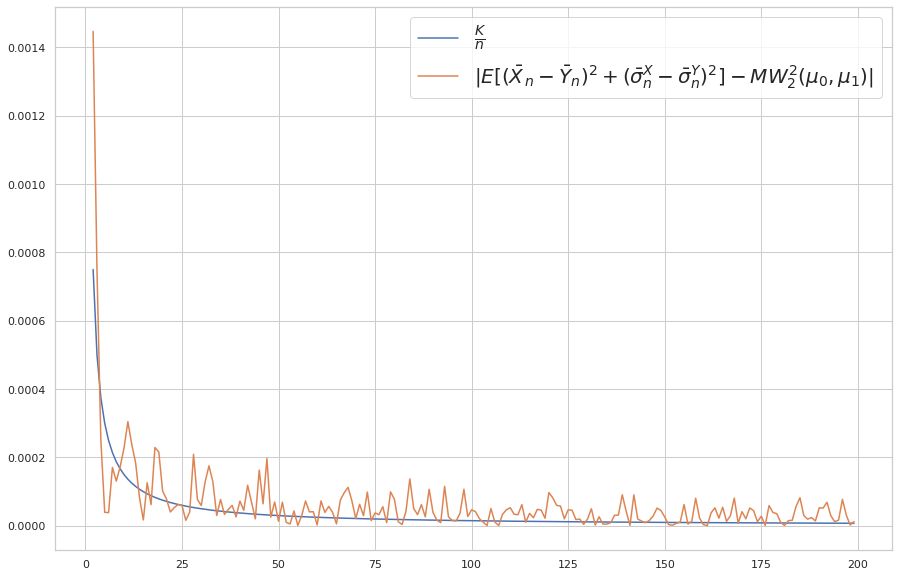

In [ ]:
pl.figure(figsize=(15,10))
ax = pl.gca()
ax.plot(list_n, 0.0015/list_n, label=r"$\frac{K}{n}$")
ax.plot(list_n, np.abs(consistences), label = r"$|E[(\bar X_n - \bar Y_n)^2 + (\bar \sigma_n^X - \bar \sigma_n^Y)^2] - MW_2^2(\mu_0, \mu_1)|$")
ax.legend(prop={'size': 20})
pl.show()

**2.   Dimension d**

\begin{aligned}
\mathbb{E}_{X,Y}[(\bar X_n - \bar Y_n)^2 + d_{Bures}^2(\bar \Sigma_n^X, \bar \Sigma_n^Y)] - MW_2^2(\mu_0, \mu_1) = \mathcal{O}(\frac{1}{n})
\end{aligned}

Where 
\begin{aligned}
d_{Bures}^2(A, B) = tr[ A + B - 2 (A^{\frac{1}{2}}BA^{\frac{1}{2}})^{\frac{1}{2}}]
\end{aligned}

and 

\begin{aligned}
MW_2^2(\mu_0, \mu_1) = ||m_0 - m_1||^2 + d^2_{Bures}(\Sigma_0, \Sigma_1)
\end{aligned}

Finally, this can be rewritten as : 

\begin{aligned}
\mathbb{E}_{X,Y}[MW_2^2(\bar \mu_0^n, \bar \mu_1^n)] - MW_2^2(\mu_0, \mu_1) = \mathcal{O}(\frac{1}{n})
\end{aligned}

Where 
\begin{aligned}
\bar \mu^n_0 \sim \mathcal{N}(\bar X_n, \bar \Sigma_n^X) \quad 
\text{ and } \quad \bar \mu^n_1 \sim \mathcal{N}(\bar Y_n, \bar \Sigma_n^Y)
\end{aligned}

## 2.a) Dimension d with any SDP covariance matrices

In [ ]:
## dimension 2

pi0 = np.array([[0.5]])
mu0 = np.array([[0.3,0.3]])
S0 = np.array([[[ .01, 0],[0,  .01]]])
pi1 = np.array([[0.45]])
mu1 = np.array([[0.5,0.6]])
S1 = np.array([[[ .01, 0],[0,  .01]]])

MW = GaussianW2(mu0,mu1,S0,S1).ravel()
consistences = []
list_n = np.arange(2, 100)
for n in list_n:
  E = expectation(pi0,mu0,S0,pi1,mu1,S1,n,dim=2)
  consistences.append(E - MW[0])

consistences = np.array(consistences)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


KeyboardInterrupt: ignored

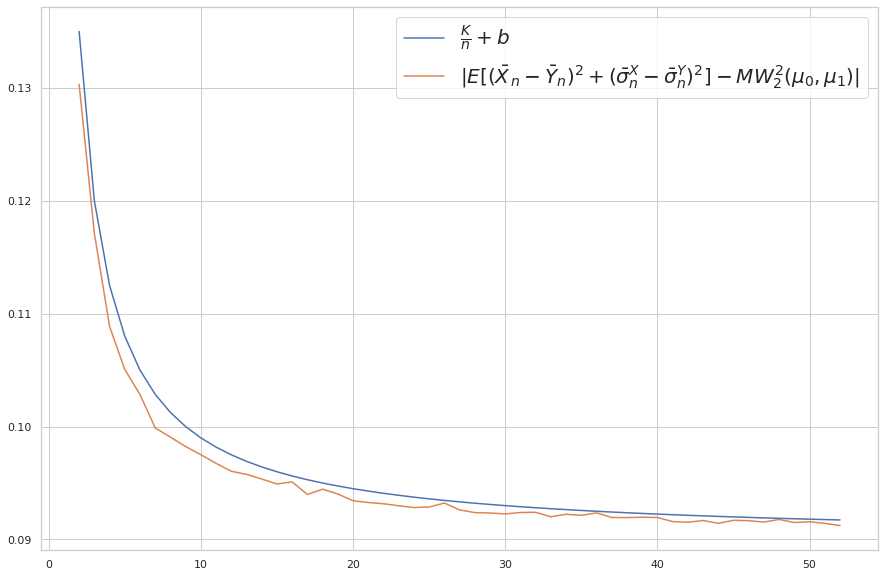

In [ ]:
pl.figure(figsize=(15,10))
ax = pl.gca()
ax.plot(list_n[:len(consistences)], 0.09/list_n[:len(consistences)] + 4.5* np.trace(S0[0]) , label=r"$\frac{K}{n} + b$")
ax.plot(list_n[:len(consistences)], np.abs(consistences), label = r"$|E[(\bar X_n - \bar Y_n)^2 + (\bar \sigma_n^X - \bar \sigma_n^Y)^2] - MW_2^2(\mu_0, \mu_1)|$")
ax.legend(prop={'size': 20})
pl.show()

## 2.b) Dimension d with diagonal covariance matrices

In [ ]:
## dimension 5
d = 5
pi0 = np.array([[0.5]])
mu0 = np.array([[0.3,0.3,0.4,0.4, 0.5]])
S0 = np.array([np.eye(5)])
pi1 = np.array([[0.45]])
mu1 = np.array([[0.5,0.6,0.6, 0.2, 0.4]])
S1 = np.array([0.1 * np.eye(5)])

MW = GaussianW2(mu0,mu1,S0,S1).ravel()
consistences = []
list_n = np.arange(2, 50)
for n in list_n:
  E = expectation(pi0,mu0,S0,pi1,mu1,S1,n,dim=d)
  consistences.append(E - MW[0])

consistences = np.array(consistences)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


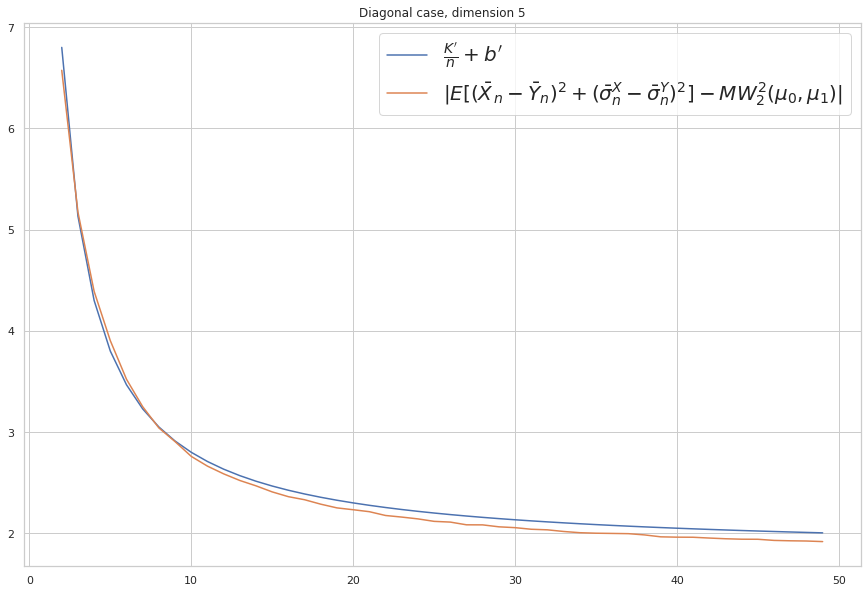

In [ ]:
pl.figure(figsize=(15,10))
ax = pl.gca()
ax.plot(list_n[:len(consistences)], 10/(list_n[:len(consistences)]) + 1.8, label=r"$\frac{K'}{n} + b'$")
ax.plot(list_n[:len(consistences)], np.abs(consistences), label = r"$|E[(\bar X_n - \bar Y_n)^2 + (\bar \sigma_n^X - \bar \sigma_n^Y)^2] - MW_2^2(\mu_0, \mu_1)|$")
ax.legend(prop={'size': 20})
pl.title("Diagonal case, dimension 5")
pl.show()

# II. For K gaussians in the mixture : MW2 $\neq$ W2